# Linear SVM, CSAR trining, Docking Scores, Pisani Residues

>

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Helper function
%run ./helper_functions_S6.ipynb

### Loading the data:

In [4]:
# Docking Scores
data_dir = '../data/docking_scores/'
# vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', 
             column_to_drop = 'ActiveInactive')
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
             column_to_drop = 'Actividad')
# Vianrdo Docking Scores (dksc) DEKOIS2
X_dksc_DEKOIS, y_dksc_DEKOIS = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
             column_to_drop = 'Actividad')

In [5]:
# Ligand Efficiency scores
data_dir = '../data/docking_scores/'
# vinardo Docking Scores (dklef) CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
            column_to_drop = 'ActiveInactive')
# Vinardo Docking Scores (dklef) CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
            column_to_drop = 'Actividad')
# Vianrdo Docking Scores (dklef) DEKOIS2
X_dkef_DEKOIS, y_dkef_DEKOIS = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DEKOIS2_VINARDO_ligand_Efficiency.csv',
            column_to_drop = 'Actividad')

In [91]:
# Dictionary of docking results (Only DkSc are included)
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}, 
                       'Dk_lef':  {'X': X_dkef_CSAR, 'y': y_dkef_CSAR} },
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}, 
                       'Dk_lef':  {'X': X_dkef_DUD,  'y': y_dkef_DUD} },
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}, 
                       'Dk_lef':  {'X': X_dkef_DEKOIS,  'y': y_dkef_DEKOIS} },
             }

#### Best conformation in DUD

In [95]:
?roc_auc_score

In [114]:
database = 'CSAR'
_y_true = scores_dic[database]['Dk_sc']['y']
# Calculating the roc_acu_value
auc_scores = scores_dic[database]['Dk_sc']['X'].apply(
    lambda x: roc_auc_score(y_true=_y_true, y_score = -1 * x), axis = 0)

_bc = auc_scores.idxmax()
_bc, auc_scores.max()

('2vv9', 0.8486425339366516)

In [111]:
database = 'DUD'
_y_true = scores_dic[database]['Dk_sc']['y']
# Calculating the roc_acu_value
auc_scores = _scores_dic[database]['Dk_sc']['X'].apply(
    lambda x: roc_auc_score(y_true=_y_true, y_score = -1 * x), axis = 0)
_bc = auc_scores.idxmax()
_bc, auc_scores.max()

('3le6', 0.6750040180006429)

In [115]:
database = 'DEKOIS'
_y_true = scores_dic[database]['Dk_sc']['y']
# Calculating the roc_acu_value
auc_scores = _scores_dic[database]['Dk_sc']['X'].apply(
    lambda x: roc_auc_score(y_true=_y_true, y_score = -1 * x), axis = 0)
_bc = auc_scores.idxmax()
_bc, auc_scores.max()

('2iw6', 0.7904375)

#### Testing

In [7]:
# Testing with the two following estimators
from sklearn.svm import SVC, LinearSVC

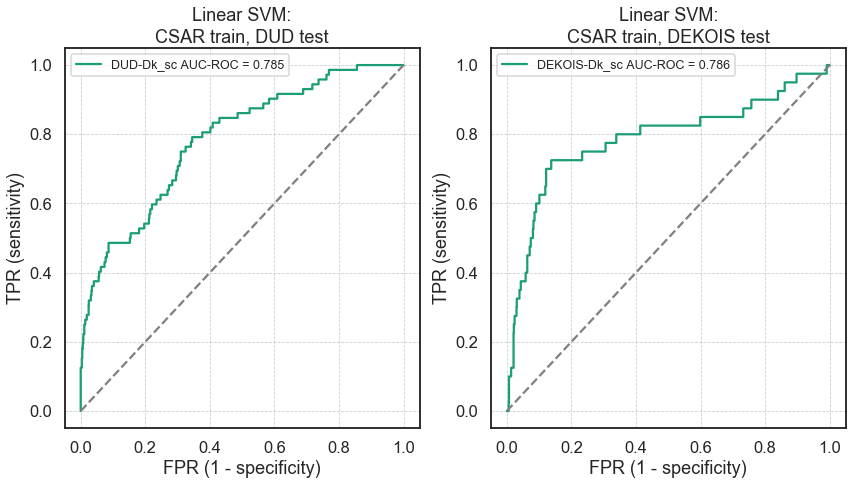

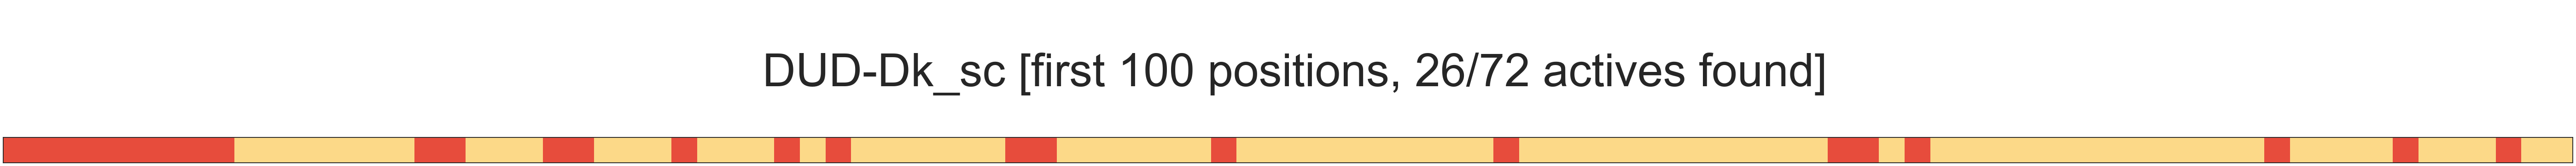

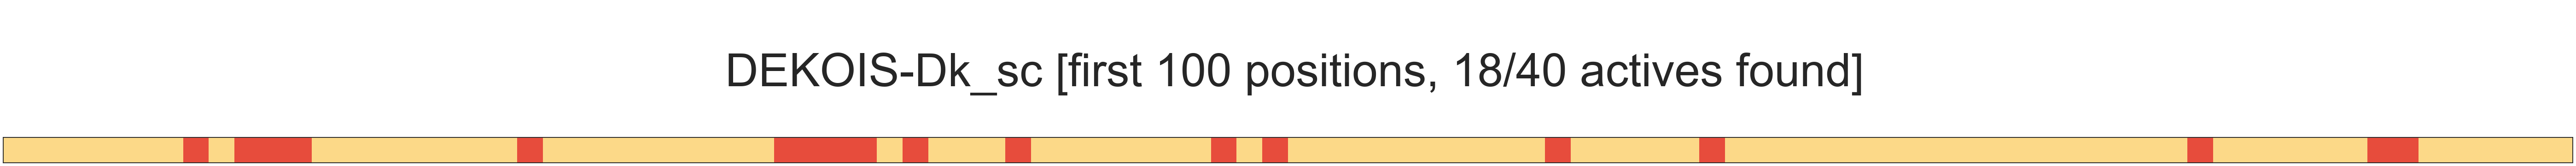

In [8]:
# first with SVC
# The best param found in the  grid search was C = 1
score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC


svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                               scores_dic = scores_dic, estimator = svm,
                               kernel = 'linear', probability = True, C = 0.1 )

svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = [score_type], 
                            scores_dic = scores_dic, decreasing = False)

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)


## Random Sampling:
Randomly choose n features for train and test.

In [9]:
import os
# Files to save the results
dud_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DUD_test.json'
dekois_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'

In [10]:
%%time

if not os.path.isfile(dud_file_rd):
    # Defining some variables and parameters
    score_type = 'Dk_sc'
    train_key = 'CSAR'
    test_keys = ['DUD', 'DEKOIS']
    C = 0.1
    model = SVC
    # Random picking parameters
    N_REPS = 50
    MIN_CONFS = 1
    MAX_CONFS = 402
    INTERVAL = 1

    # Then we create the dataframes to store the results
    list_of_columns = [F'rep_{i}' for i in range(N_REPS)]

    # Two dataframes, one for DUD and one for DEKOIS
    df_rdPick_DUD_lsvc = pd.DataFrame(columns = list_of_columns)
    df_rdPick_DEKOIS_lsvc = pd.DataFrame(columns = list_of_columns)


    # Run the loop
    for N_CONFS in range(MIN_CONFS, MAX_CONFS + 1, INTERVAL):
        if N_CONFS%(10) == 0:
             print(F'Iteración: {N_CONFS}')
        n_conf_row = random_confs_picking(scores_dic = scores_dic, score_type = score_type,
                                 train_key = train_key, test_keys = test_keys,
                                 n_features = N_CONFS, n_reps = N_REPS,
                                 # Exclusive hyperparameters for the selected model
                                 model = model, C = C, kernel = 'linear', probability = True)
        # Add the result to the corresponding row
        df_rdPick_DUD_lsvc.loc[ N_CONFS ] = n_conf_row['DUD']
        df_rdPick_DEKOIS_lsvc.loc[ N_CONFS ] = n_conf_row['DEKOIS']

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 56.7 µs


In [11]:
# Save the results
if os.path.isfile(dud_file_rd):
    df_rdPick_DUD_lsvc = pd.read_json(dud_file_rd)
else:
    df_rdPick_DUD_lsvc.to_json()

if os.path.isfile(dekois_file_rd):
    df_rdPick_DEKOIS_lsvc = pd.read_json(dekois_file_rd)
else:
    df_rdPick_DEKOIS_lsvc.to_json()

### Plotting the results

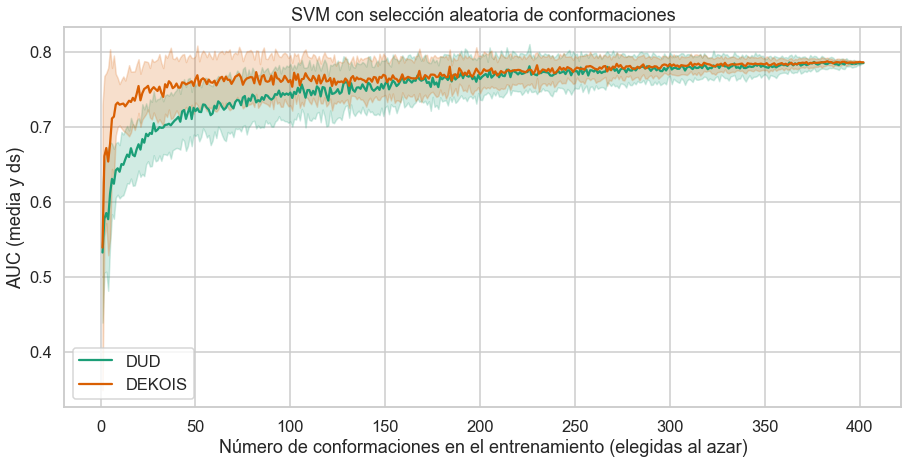

In [12]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')
plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

## K-means clustering

In [13]:
# Read the MDS resuts
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

#### Performs the k-means clustering

In [14]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
output_notebook()

Loading BokehJS ...

In [15]:
# Kmeans over the first two dimensions
fd = 2
_X = mds_pisani_402[0][:fd].T

n_clusters = 20
kmc = KMeans(n_clusters = n_clusters, random_state = 0)
kmc.fit( _X )

# Create the datasource
data_mds = ColumnDataSource({
    'x': _X.T[0],
    'y': _X.T[1],
    'cluster': kmc.labels_.astype('str')
})
CLUSTERS = np.unique(kmc.labels_.astype('str'))
color_map = factor_cmap('cluster', palette= viridis(len(CLUSTERS)), factors = CLUSTERS)

# Create the colors

f = figure(title = F'K-Means clustering (k = {n_clusters})', active_scroll='wheel_zoom')
# Plot the reference space
f.circle('x', 'y', color = color_map, source = data_mds, size = 6)

# Plot the centroids
f.triangle(x = kmc.cluster_centers_[:,0], 
           y = kmc.cluster_centers_[:,1], color = (220,20,60, 0.5), size = 10,
          line_color = 'black', legend_label = 'Centroids')
# Plot the medoids
medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = n_clusters,
                             random_state = 0)
_X_medoids = _X[ medoids_idx, :]
# Plot medoids
f.circle(x = _X_medoids.T[0], 
           y = _X_medoids.T[1], color = (255, 241, 116, 0), size = 10,
          line_color = 'black',  legend_label = 'Medoids')

show(f)

#### Elbow method using cluster inertia

In [16]:
K = 50
distortions = np.zeros(K)

for k in range(K):
    kmc = KMeans(n_clusters = k + 1, random_state = 0)
    kmc.fit(_X)
    distortions[k] = kmc.inertia_

In [17]:
f_2 = figure(title='Elbow method for kmeans clustering', plot_width = 900, plot_height = 300)
f_2.line(x = range(1, K+1), y = distortions)
f_2.circle(x = range(1, K+1), y = distortions)
f_2.xaxis.axis_label = 'k clusters'
f_2.yaxis.axis_label = 'Distortion'
show(f_2)

In [20]:
%%time

score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC
model_extra_params = dict(kernel = 'linear', probability = True, C = 0.1)
metric = 'roc_auc'

MAX_N_CONFS = 402

# Creates the dictionary of results to be filled and returned
# Saving to pandas dataframe
output_dir = '../data/ml_evaluations/'
file_name_kmeans = F'{output_dir}/KMEANS_sampling_1_to_402_features_CSAR_train_DUD_DKOIS_test_pisani_MDS.json'

if os.path.isfile(file_name_kmeans):
    # Load the file
    df_kmeans_results = pd.read_json(file_name_kmeans)
else: # Run the code and save the file
    results_dict = {}
    for test in test_keys:
        results_dict[test] = np.zeros(MAX_N_CONFS)


    for i in range(MAX_N_CONFS):
        # Selection of k conformations using K-Means
        k = i + 1
        medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = k,
                                     random_state = 0)
        features = scores_dic[train_key][score_type]['X'].columns[medoids_idx]

        # Performs the LinearSVC
        model_train = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                                    scores_dic = scores_dic, estimator = model,
                                    selected_features= features,
                                    **model_extra_params)

        model_pred = eval_wrapper(trained_model = model_train, 
                                    test_keys = test_keys, list_of_scores = [score_type], 
                                    selected_features= features,
                                    scores_dic = scores_dic, decreasing = False)

        for test in test_keys:
                metric_value = model_pred[test].format_metric_results(metric).values[0][0]
                results_dict[test][i] = metric_value

    df_kmeans_results = pd.DataFrame(results_dict)
    df_kmeans_results.to_json(file_name_kmeans)

CPU times: user 7.1 ms, sys: 0 ns, total: 7.1 ms
Wall time: 6.29 ms


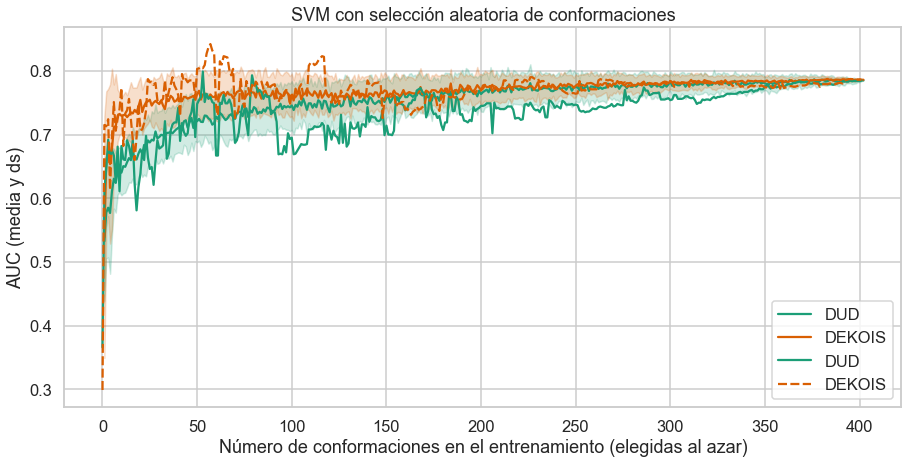

In [21]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')

#sns.lineplot(x = range(1, 403), y = results_dict['DEKOIS'], 
#             label = 'DEKOIS kmeans')
#sns.lineplot(x = range(1, 403), y = results_dict['DUD'], 
#             label = 'DUD kmeans')
sns.lineplot(data = df_kmeans_results)

plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

## Consensus Scoring

Source: _[Exponential consensus ranking improves the outcome in docking and receptor ensemble docking](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6435795/)_


We start computing the list of conformations for each $k$ value in k-means, this is because in all function calls we are using a `random_state` parameter which means the conformations considered as medoids would be the same each time. Therefore we compute them once to avoid recompute *k-means clustering* each time.

In [49]:
%%time
# Precomputed clustering with k-means
import pickle
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 35.5 ms


### Defining some vaiables to be used in the following cells

In [23]:
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1

# Dictionary of scores to be evaluated
# List of datasets to be used as test
scores_dic
score_types = ['Dk_sc']
dataset_names = ['DUD', 'DEKOIS']

In [24]:
import pickle, os

def consensus_wrapper(func, scores_dic, score_types, dataset_names, consensus_name, 
                             file_path = '../data/ml_evaluations/', file_sufix = '', method = 'random',
                             min_confs = 1, max_confs = 402, interval = 1, n_reps = 50, 
                             **kwargs):
    # File name
    file_name = file_path + '_'.join(dataset_names) + \
            F'_{method}_Cons_{consensus_name}' + file_sufix + '.obj'
    # Check if the file exist
    if os.path.isfile(file_name):
        with open(file_name, 'rb') as f:
            _results_dict = pickle.load(f)
    else:
        _results_dict = {}
        for dataset in dataset_names:
            for score in score_types:
                key_name = F'{dataset}_{score.replace("_", "")}_{method}_Cons_{consensus_name}'
                df_X = scores_dic[dataset][score]['X']
                df_y = scores_dic[dataset][score]['y']
                if method == 'random':
                    df_aucs = random_picking_consensus(func, df_X, df_y, 
                                         min_confs, max_confs, interval, n_reps, **kwargs)
                elif method == 'kmeans':
                    df_aucs = kmeans_picking_consensus(func, df_X, df_y, 
                                     min_confs, max_confs, interval, **kwargs)
                else:
                    print('Wrong method for conformations selection ("random", "kmeans").')
                # Add to the dictionary of results
                _results_dict[key_name] = df_aucs
        # Saves the dictionary
        with open(file_name, 'wb') as f:
            pickle.dump(_results_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    return(_results_dict)

### *Rank by number*

> The final score of each ligand $i$ ($R_bN_i$) corresponds to the *mean score* of ligand $i$ from a set of $n$ conformations.

> $R_bN_i = \frac{1}{n}\sum_js_i^j,$

where $n$ is the number of conformations, and $s_i^j$ is the docking score of the molecule $i$ with the $j$ conformation.
#### Rank by number with conformations ramdomly selected
- Randomly select n conformations.
- Compute the mean score for each ligand.
- Get the AUC of the final ranking.

In [25]:
def get_rank_by_number(df):
    '''Get a dataframe of m*n values and returns a numpy array of means per row'''
    df_means = df.mean(axis = 1)
    # (times -1 because roc_auc_score in the following line assumes higher is better)
    return df_means.to_numpy() * -1

#### Random Selection

In [26]:
%%time
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'random'

Rbn_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                dataset_names, consensus_name, method = method)

CPU times: user 1.83 ms, sys: 23 µs, total: 1.85 ms
Wall time: 1.16 ms


#### k-means Selection

In [27]:
%%time
func = get_rank_by_number
consensus_name = 'Rbn'
method = 'kmeans'

Rbn_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k)

CPU times: user 317 µs, sys: 0 ns, total: 317 µs
Wall time: 181 µs


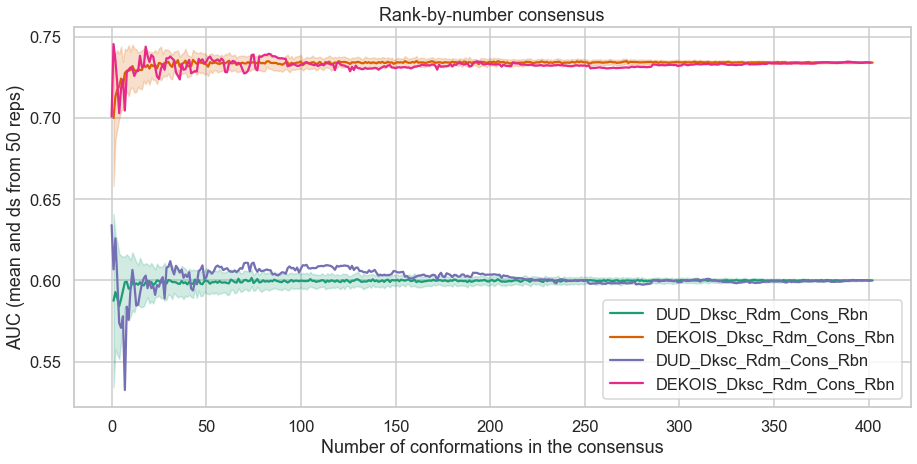

In [28]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rbn_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key)
# k-means picking
for key, df in Rbn_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key)
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')
plt.show()

### Best score

Also mentioned as *Merging and shrinking strategy* by Palacio-Rodríguez, et al. (2019).

For each molecule $i$, get the lowest score of the $n$ scores calculated.
> $best\ score_i = min(s_i),$

where $s_i$ is an array of $n$ scores, belonging to the molecule $i$, in which each position $j$ corresponds to the docking score between the molecule $i$ and the protein conformation $j$.

In [29]:
def get_best_score(df):
    '''Get a dataframe of m*n values and returns a numpy array of best scores per row'''
    df_best = df.min(axis = 1)
    # (times -1 because roc_auc_score in the following line assumes higher is better)
    return df_best.to_numpy() * -1

#### Random Selection

In [30]:
%%time
func = get_best_score
consensus_name = 'Rbs'
method = 'random'

Rbs_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                dataset_names, consensus_name, method = method)

CPU times: user 1.94 ms, sys: 25 µs, total: 1.96 ms
Wall time: 2.26 ms


#### k-means Selection

In [31]:
%%time
func = get_best_score
consensus_name = 'Rbs'
method = 'kmeans'

Rbs_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k)

CPU times: user 1.06 ms, sys: 13 µs, total: 1.07 ms
Wall time: 557 µs


#### Visualization

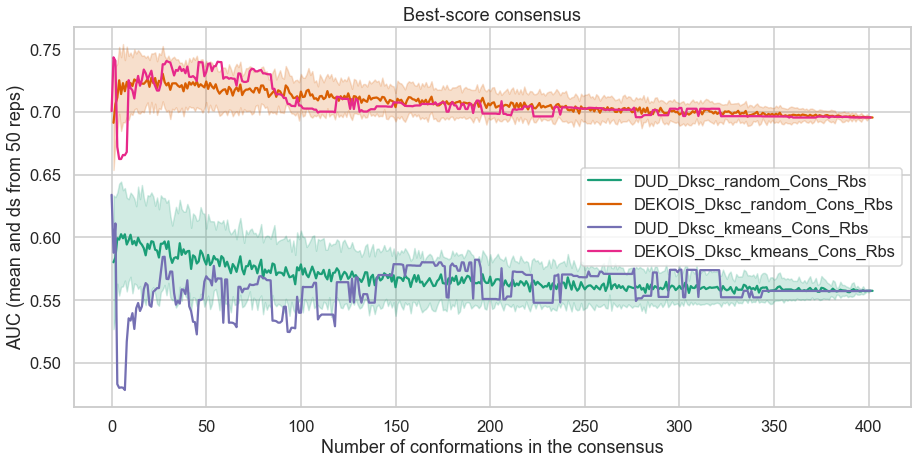

In [32]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rbs_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key)
# k-means picking
for key, df in Rbs_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key)
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Best-score consensus')
plt.show()

### *Rank-by-rank*

For each conformation $j$ the $m$ molecules are ranked according to their docking score in that conformation, i.e.the molecule with the best score is assigned with the value 1, the second one with the best score is assigned with the value 2, and so on, until the molecule with the worst value is assigned with the value $m$. Finally, the average rank of each molecule is compute taking into account its rank in all the $n$ conformations.

> $R_bR_i = \frac{1}{n}\sum_jr^i_j,$

where $n$ is the number of protein conformations, and $r^i_j$ is the rank position of the molecule $i$ in the ranked score obtained in the protein conformation $j$.

In [33]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # First, we get the ranking positions
    # For each ligand i we get the average score among the n conformations
    df_rank_by_rank = df_ranks.mean(axis = 1)
    return df_rank_by_rank.to_numpy() * -1

#### Random Selection

In [34]:
%%time
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'random'

Rbr_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                       dataset_names, consensus_name, method = method)

CPU times: user 2.06 ms, sys: 0 ns, total: 2.06 ms
Wall time: 1.26 ms


#### K-means Selection

In [35]:
%%time
func = get_rank_by_rank
consensus_name = 'Rbr'
method = 'kmeans'

Rbr_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k)

CPU times: user 474 µs, sys: 4 µs, total: 478 µs
Wall time: 268 µs


#### Visualization

Text(0.5, 1.0, 'Rank-by-number consensus')

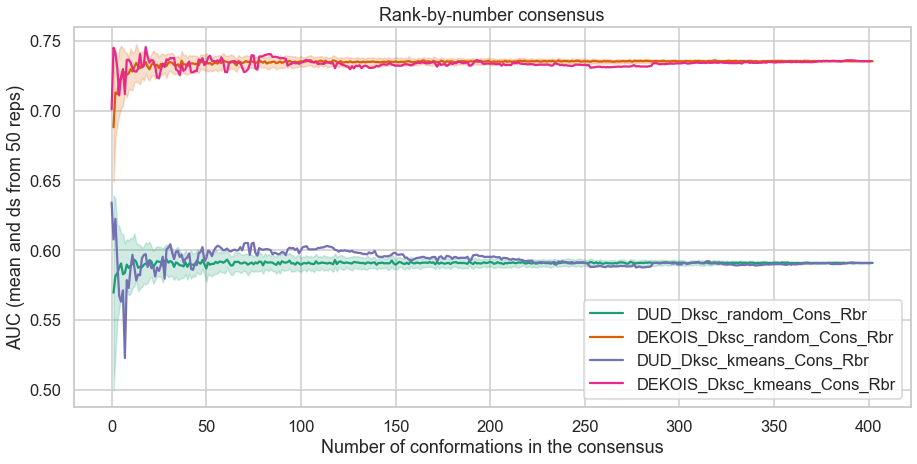

In [36]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rbr_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key)
# k-means picking
for key, df in Rbr_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key)
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')

## *Rank-by-vote*
Each molecule $i$ receives a vote if it ranked on top $x\%$ of the results in each conformation. The final score of the molecule is given by  the sum of vote obtained from all the protein conformations.

> $R_bV_i(\chi) = \frac{1}{n}\sum_jr^i_j,$

TODO: same basis as the Enrichment Factor Metric.

Let's prove with $x = 1\%$:

In [37]:
def get_rank_by_vote(df, chi = 10, weighted = True):
    # ascending=True; lower values get lower positions
    df_ranks = df.rank(ascending=True) 
    # First, we get the ranking positions
    # Get the number of molecules inside chi
    x = np.floor(df.shape[0]/100 * chi)
    # Convert to a numpy array
    rbr_array = df_ranks.to_numpy()
    # Apply the filter
    # We are using a trick here because in the final array all values are going to be
    # negative, and the best ligands will have the higest values, been -1 the highest possible
    replace_value = rbr_array if weighted else 1
    rbr_array = np.where(rbr_array > x, df.shape[1], replace_value)
    # Get the mean value per row
    rbr_means = (rbr_array.mean(axis = 1) * (- 1))
    return rbr_means

#### Random Selection (unweighted)

In [66]:
%%time
func = get_rank_by_vote
consensus_name = 'Rbv'
method = 'random'
weighted = False

chi = 1
file_sufix = F'_uw_c{chi}'
# Chi = 2
Rbv_uw_c1_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                dataset_names, consensus_name, method = method,
                                file_sufix = file_sufix, chi = chi, weighted = weighted)
chi = 2
file_sufix = F'_uw_c{chi}'
# Chi = 2
Rbv_uw_c2_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                dataset_names, consensus_name, method = method,
                                file_sufix = file_sufix, chi = chi, weighted = weighted)
chi = 5
file_sufix = F'_uw_c{chi}'
# Chi = 5
Rbv_uw_c5_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                dataset_names, consensus_name, method = method,
                                file_sufix = file_sufix, chi = chi, weighted = weighted)

CPU times: user 4.35 ms, sys: 0 ns, total: 4.35 ms
Wall time: 64.5 ms


####  K-means selection

In [64]:
%%time
func = get_rank_by_vote
consensus_name = 'Rbv'
method = 'kmeans'
weighted = False

chi = 1
file_sufix = F'_uw_c{chi}'

Rbv_uw_c1_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k,
                        file_sufix = file_sufix, chi = chi, weighted = weighted)

chi = 2
file_sufix = F'_uw_c{chi}'

Rbv_uw_c2_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k,
                        file_sufix = file_sufix, chi = chi, weighted = weighted)

chi = 5
file_sufix = F'_uw_c{chi}'
Rbv_uw_c5_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k,
                        file_sufix = file_sufix, chi = chi, weighted = weighted)

CPU times: user 1.26 ms, sys: 49 µs, total: 1.31 ms
Wall time: 743 µs


### Visualization

Text(0.5, 1.0, 'Rank-by-number consensus')

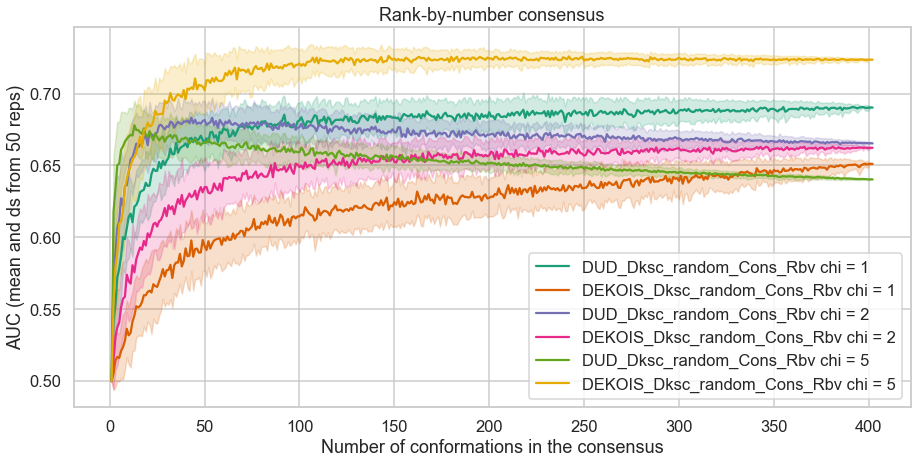

In [67]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rbv_uw_c1_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key + ' chi = 1')
for key, df in Rbv_uw_c2_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key + ' chi = 2')
for key, df in Rbv_uw_c5_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key + ' chi = 5')
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')

Text(0.5, 1.0, 'Rank-by-number consensus')

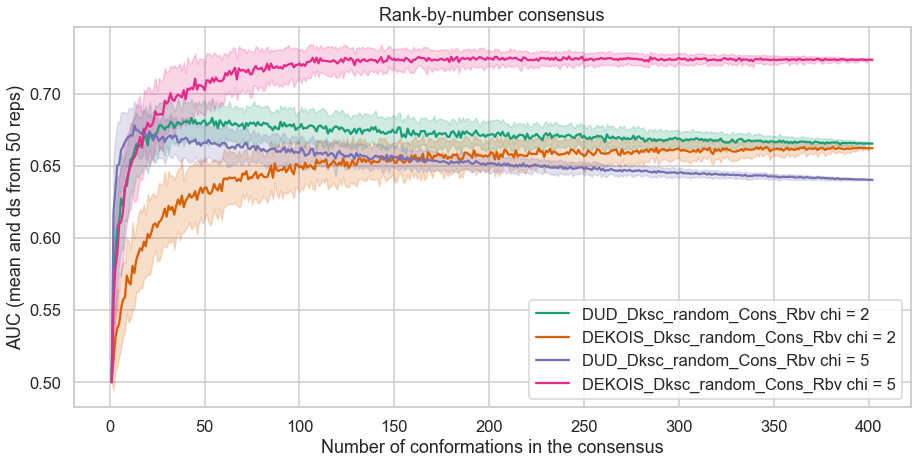

In [56]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rbv_uw_c2_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key + ' chi = 2')
for key, df in Rbv_uw_c5_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key + ' chi = 5')
# k-means picking
for key, df in Rbv_uw_c2_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key + ' chi = 2')
for key, df in Rbv_uw_c5_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key + ' chi = 5')
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')

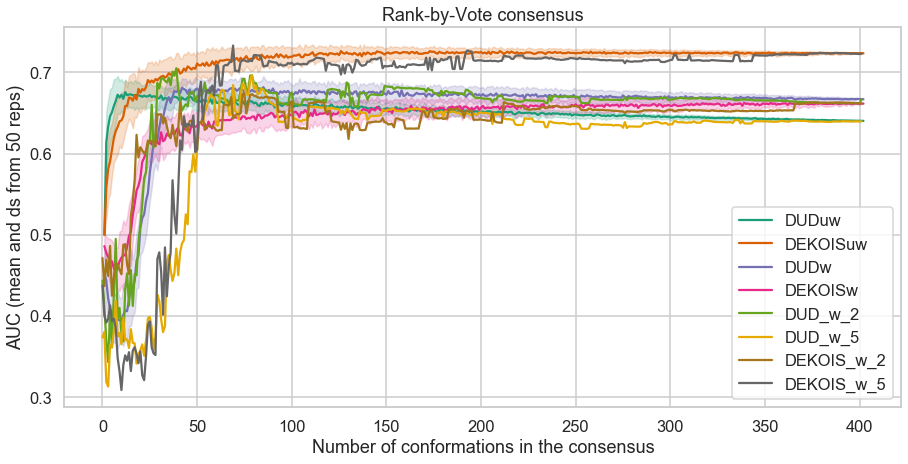

In [392]:

plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbv_uw2_DUD.melt(), ci = 'sd', label = 'DUDuw')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbv_uw2_DEKOIS.melt(), ci = 'sd', label = 'DEKOISuw')

sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbv_w2_DUD.melt(), ci = 'sd', label = 'DUDw')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbv_w2_DEKOIS.melt(), ci = 'sd', label = 'DEKOISw')

for key in kmeans_dict_rbv:
    if '_w' in key:
        df_ = pd.DataFrame({key: kmeans_dict_rbv[key]})
        sns.lineplot(x = 'variable', y = 'value', 
                     data = df_.T.melt(), ci = 'sd', label = key)

plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-Vote consensus')
plt.show()

### Exponential Consensus Ranking
It follows the same idea than the RIE and BEDROC metrics, taking into account the position of each molecule inside the ranked results following a exponential distribution. It is proposed by Palacio-Rodríguez, et al. (2019) as a scoring consensus using different docking programs:

> "*Exponential Consensus Ranking (ECR), a strategy to combine the results from
several scoring functions/docking programs using an exponential distribution for each individual rank.*"

For each molecule $i$ at the protein conformation $j$ the *exponential score* $p(r^j_i)$ is calculated as follows:

> $$p(r^j_i) = \frac{1}{\sigma}exp\left( - \frac{r_i^j}{\sigma} \right),$$

where $p(r^j_i)$ is the rank of the molecule $i$ in the docking scoring results of the protein conformation $j$, and $\sigma$ is the expected value of the exponential distribution. Just to remember, the exponential distribution (in the form $f(x) = \lambda e^{(- \lambda x)}$) has a mean and an standard deviation of $1/\lambda$ which here in $ECR$ is referred as $\sigma$: ($\sigma = 1 / \lambda$). As was said in a previous notebook for RIE and BEDROC metrics, the parameter $\sigma$ can be understood as a fraction of the ranked list where the weight is important.
As said by Palacio-Rodríguez, et al.:
> "*This parameter $(\sigma)$ establishes the number of molecules for each scoring function that will be considered, i.e., the threshold of the dataset to be taken into account for the consensus. *"

Finally, the final $ECR$ score $P(i)$ of each molecule $i$ is computed as follows:

> $$P(i) = \sum_{j=1}^n p(r^j_i) = \frac{1}{\sigma} \sum_{j=1}^n exp\left( - \frac{r_i^j}{\sigma} \right)$$

In [68]:
def get_exp_consensus_ranking(df, sigma = 2):
    # ascending=True; lower values get lower positions
    ranks_array = df.rank(ascending=True).to_numpy()
    # Apply the exponential function
    exp_ranks = (1/ sigma)*(np.exp( - ranks_array/sigma))
    
    # For each ligand i we get the average score among the n conformations
    ecs = exp_ranks.sum(axis = 1)
    return ecs

In [116]:
%%time
func = get_exp_consensus_ranking
consensus_name = 'Rexp'
method = 'random'
sigma = 2
file_sufix = F'_sig{sigma}'

Rexp_s2_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                       dataset_names, consensus_name, method = method,
                                sigma = sigma, file_sufix = file_sufix)

sigma = 5
file_sufix = F'_sig{sigma}'

Rexp_s5_rd_dict = consensus_wrapper(func, scores_dic, score_types, 
                                       dataset_names, consensus_name, method = method,
                                sigma = sigma, file_sufix = file_sufix)

CPU times: user 16min 41s, sys: 32.1 s, total: 17min 13s
Wall time: 17min 13s


In [117]:
%%time
func = get_exp_consensus_ranking
consensus_name = 'Rexp'
method = 'kmeans'
sigma = 2
file_sufix = F'_sig{sigma}'

Rbr_s2_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k,
                                sigma = sigma, file_sufix = file_sufix)

sigma = 5
file_sufix = F'_sig{sigma}'

Rbr_s5_km_dict = consensus_wrapper(func, scores_dic, score_types, 
                  dataset_names, consensus_name, method = method,
                  data_to_clust = mds_pisani_402[0], n_dims = 2,
                  random_state = 0, df_precomputed_medoids = df_confs_per_k,
                                sigma = sigma, file_sufix = file_sufix)

CPU times: user 21.2 s, sys: 952 ms, total: 22.2 s
Wall time: 22.2 s


#### Visualization

Text(0.5, 1.0, 'Rank-by-number consensus')

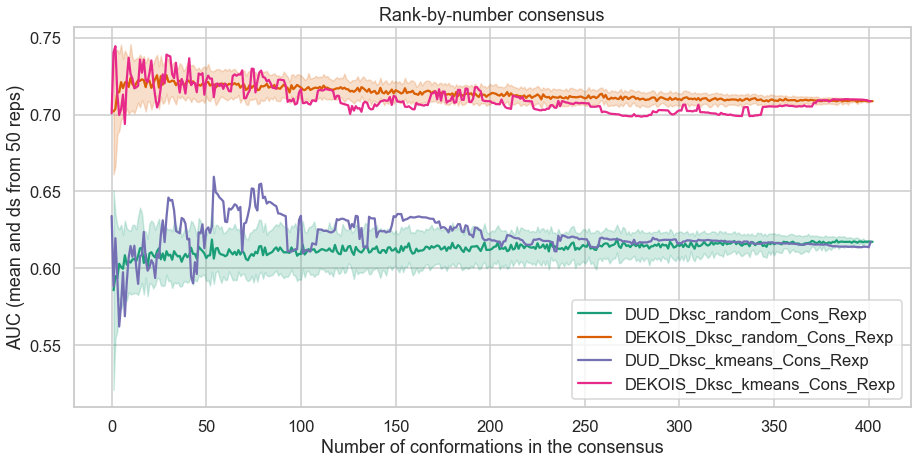

In [73]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# Random picking
for key, df in Rexp_rd_dict.items():
    sns.lineplot(x = 'variable', y = 'value', data = df.melt(), ci = 'sd', label = key)
# k-means picking
for key, df in Rbr_km_dict.items():
    df_ = pd.DataFrame({key: df}).T
    sns.lineplot(x = 'variable', y = 'value', data = df_.melt(), ci = 'sd', label = key)
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')
plt.show()